### Q1: Exploratory Data Analysis (5 Pts)
Get familiar with the dataset by exploring the different features, their distribution, and the labels.
Check for common pitfalls like missing or nonsensical data, unusual feature distribution, outliers,
or class imbalance, and describe how to handle them. After having familiarized yourself with the
data, explain how you preprocess the dataset for the remaining tasks of part 1. Interpretabilityand explainability aim at gaining more insights about the data than just optimizing predictive
performance. A first simple step is to have a look at the (linear) dependencies of the variables.
Visualize the pairwise correlation matrix and describe which features seem to be important for
predicting the label.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
data_frame = pd.read_csv("data/heart_failure/train_val_split.csv")

In [2]:
data_frame.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


In [3]:
print("Shape:", data_frame.shape)
print("#positive samples: ", len(data_frame.HeartDisease[data_frame.HeartDisease == 1]))
print("#negative samples: ", len(data_frame.HeartDisease[data_frame.HeartDisease == 0]))

Shape: (734, 12)
#positive samples:  398
#negative samples:  336


As we can see, there are slightly more positive samples than negative ones - but the labels are still fairly balanced.
We now look for missing values: Cholesterol seems to have some 0s - probably missing values : impute them or delete? -- too many (19% of all samples, hence impute with mean)

We note that the following columns are categorical, hence convert their dtype from `object` to `category`

In [4]:
data_frame.Sex.unique(), data_frame.ChestPainType.unique(), data_frame.RestingECG.unique(), data_frame.ExerciseAngina.unique(), data_frame.ST_Slope.unique()

(array(['M', 'F'], dtype=object),
 array(['ATA', 'ASY', 'NAP', 'TA'], dtype=object),
 array(['Normal', 'ST', 'LVH'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Up', 'Flat', 'Down'], dtype=object))

In [5]:
data_frame.Sex = data_frame.Sex.astype("category")
data_frame.ChestPainType = data_frame.ChestPainType.astype("category")
data_frame.RestingECG = data_frame.RestingECG.astype("category")
data_frame.ExerciseAngina = data_frame.ExerciseAngina.astype("category")
data_frame.ST_Slope = data_frame.ST_Slope.astype("category")

#### Missing values / non sensical data
After making boxplots of each of real-valued features, we found that Cholesterol and RestingBP have non-sensical data. Below we
1. Impute the 0-values in Cholesterol with the mean
2. Drop the single row with RestingBP = 0.

In [6]:
print(len(data_frame.Cholesterol[data_frame.Cholesterol == 0]) / len(data_frame))

0.19209809264305178


/tmp/ipykernel_96004/3108665415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame["Cholesterol"][data_frame.Cholesterol[data_frame.Cholesterol == 0].index] = zero_excluded_mean


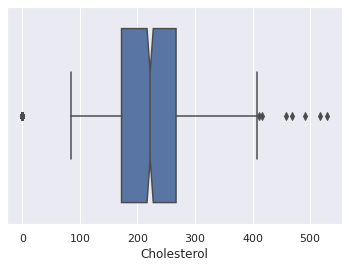

In [7]:
sns.boxplot(data=data_frame, x="Cholesterol", notch=True).get_figure().savefig("1_1_chol_a.pdf")
zero_excluded_mean = data_frame.Cholesterol[data_frame.Cholesterol != 0].mean()
data_frame["Cholesterol"][data_frame.Cholesterol[data_frame.Cholesterol == 0].index] = zero_excluded_mean

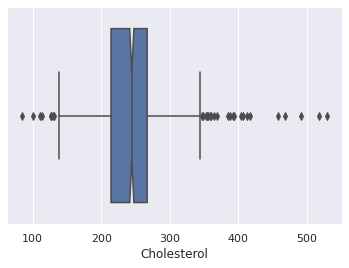

In [8]:
chorr_plot_b = sns.boxplot(data=data_frame, x="Cholesterol", notch=True)
chorr_plot_b.get_figure().savefig("1_1_chol_b.pdf")

<Axes: xlabel='RestingBP'>

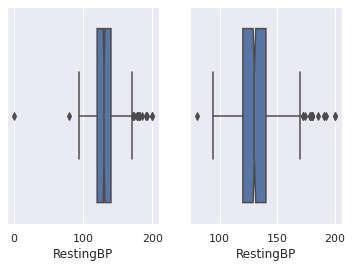

In [9]:

fig, axes = plt.subplots(1,2)
sns.boxplot(data=data_frame, x="RestingBP", notch=True,ax=axes[0])
data_frame = data_frame.drop(data_frame.RestingBP[data_frame.RestingBP < 75].index)
data_frame.describe()
sns.boxplot(data=data_frame, x="RestingBP", notch=True,ax=axes[1])

#### Visualizing pairwise correlation
We see that high values of Age, Cholesterol, FastingBS, OldPeak and low values of MaxHR are predictive of HeartDisease. We also see the inter-feature correlation in the plotted heatmap.

/tmp/ipykernel_96004/1354986292.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_frame.corr()


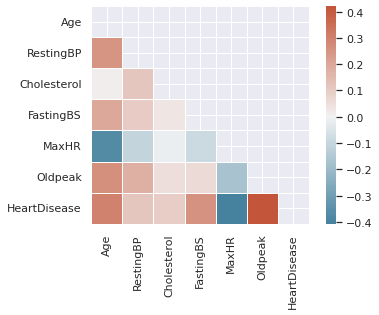

In [10]:
#sns.pairplot(data=data_frame, hue="HeartDisease")
corr = data_frame.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr_plot = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5)
corr_plot.get_figure().savefig("1_1_corr.pdf", bbox_inches='tight')


### Q2: Logistic Lasso Regression
By design, linear models are interpretable due to the weights that intuitively provide feature
importance values. Further, we can perform l1 regularization to sparsify weights, allowing us to
understand which features do not contribute to the outcome. For this question, fit a Lasso
regression model with l1 regularization on the dataset. What preprocessing step is crucial to
ensure comparability of feature coefficients? Provide performance metrics such as f1-score or
balanced accuracy to quantify the performance of this model. Visualize the importance of the
different features and present how they contribute to the model's output. Finally, argue for or
against fitting a logistic regression using only the important variables, as determined by the
Lasso model, to arrive at the final coefficients instead of keeping the coefficients of the Lasso
model.

**Answers:**
1. Normalization is crucial to ensure comparability of feature coefficients
2. Visualized feature coeff values as a bar chart
3. Fitting a logistic regression model with only the "important features" results in similar accuracy. This might be desirable as it is more intuitive/interpretable than assigning near-zero weights to the unimportant features. Further, when we train a decision tree classifier, having fewer features would lead to a simpler decision path - which also helps with interpretability. However, when using more complex models like MLP, retaining all features results in better accuracy.

In [11]:
target_label = data_frame.pop("HeartDisease")

In [12]:
from sklearn.linear_model import LogisticRegression
categorical_columns = data_frame.select_dtypes('category').columns
data_frame[categorical_columns] = data_frame[categorical_columns].apply(lambda x: x.cat.codes)

In [13]:
normalized_df=(data_frame-data_frame.mean())/data_frame.std()
normalized_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,-1.434242,0.530174,0.212572,0.431444,0.873972,-0.551231,0.008611,1.414952,-0.82012,-0.806422,1.035714
1,-1.752463,0.530174,0.212572,-0.124744,0.755948,-0.551231,1.586578,-1.505069,-0.82012,-0.806422,1.035714
2,-0.585650,-1.883600,-0.847394,0.320207,-0.601335,-0.551231,0.008611,-1.110472,1.21767,0.578986,-0.618269
3,0.050794,0.530174,1.272537,0.987632,-0.975079,-0.551231,0.008611,-0.558035,-0.82012,-0.806422,1.035714
4,-1.540315,0.530174,1.272537,-0.680932,1.857511,-0.551231,0.008611,1.336033,-0.82012,-0.806422,1.035714


In [14]:
data_frame = normalized_df
lr_classifier = LogisticRegression(solver='saga', penalty='l1', max_iter=2000).fit(data_frame, target_label)

In [15]:
predictions = lr_classifier.predict_proba(data_frame)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy - training set
accuracy = np.sum(predicted_labels == target_label) / len(target_label)
print("Accuracy: %f" % accuracy)

Accuracy: 0.860846


In [16]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
confusion_matrix(target_label, predicted_labels)

array([[285,  51],
       [ 51, 346]])

In [17]:
test_frame = pd.read_csv("data/heart_failure/test_split.csv")
test_frame[categorical_columns] = test_frame[categorical_columns].astype('category')
test_frame[categorical_columns] = test_frame[categorical_columns].apply(lambda x: x.cat.codes)

In [18]:
test_target = test_frame.pop("HeartDisease")
test_frame = (test_frame-test_frame.mean())/test_frame.std() #normalize
predictions = lr_classifier.predict_proba(test_frame)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy - test set
accuracy = np.sum(predicted_labels == test_target) / len(test_target)
print("Accuracy: %f" % accuracy)
print(confusion_matrix(test_target, predicted_labels), "\n", 
      precision_score(test_target, predicted_labels), recall_score(test_target, predicted_labels), 
      f1_score(test_target, predicted_labels))

Accuracy: 0.793478
[[59 15]
 [23 87]] 
 0.8529411764705882 0.7909090909090909 0.820754716981132


In [19]:
lr_classifier.coef_[0].shape
data_frame.columns.to_numpy().shape

(11,)

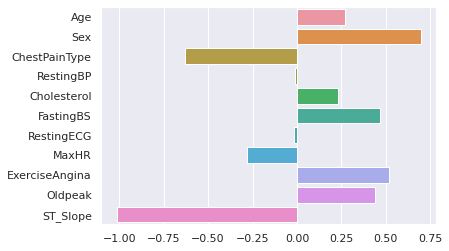

In [20]:
sns.barplot(y=data_frame.columns.to_numpy(), x=lr_classifier.coef_[0],orient='h').get_figure().savefig("1_2_coeff.pdf", bbox_inches='tight')

**Fitting only with "important" variables**
We can try to fit logistic regression model (with L2 loss) dropping the RestingBP and RestingECG variables.

In [21]:
data_frame_truncated = data_frame.drop(columns=['RestingBP', 'RestingECG'])
lr_classifier = LogisticRegression(solver='lbfgs', max_iter=2000).fit(data_frame_truncated, target_label)

predictions = lr_classifier.predict_proba(data_frame_truncated)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy - training set
accuracy = np.sum(predicted_labels == target_label) / len(target_label)
print("Accuracy: %f" % accuracy)

Accuracy: 0.860846


In [22]:
test_frame_truncated = test_frame.drop(columns=['RestingBP', 'RestingECG'])
predictions = lr_classifier.predict_proba(test_frame_truncated)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy - test set
accuracy = np.sum(predicted_labels == test_target) / len(test_target)
print("Accuracy: %f" % accuracy)
print(confusion_matrix(test_target, predicted_labels), "\n", 
      precision_score(test_target, predicted_labels), recall_score(test_target, predicted_labels), 
      f1_score(test_target, predicted_labels))

Accuracy: 0.798913
[[59 15]
 [22 88]] 
 0.8543689320388349 0.8 0.8262910798122066


Here, we visualize the coefficients. We see that the weights are quite similar to the ones learned by the full Lasso model, which explains th similarity in performance metrics.

<Axes: >

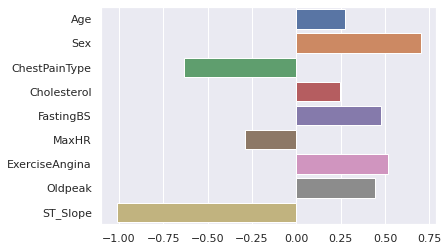

In [23]:
sns.barplot(y=data_frame_truncated.columns.to_numpy(), x=lr_classifier.coef_[0],orient='h')

### Q3: Decision Trees (3 Pts)
Like linear models, decision trees are intrinsically interpretable models by nature. For a given
output, we can retrace every decision that led to the final prediction by following the path of a
sample along the edges of the tree. Further, the models' impurity measure allows us to quantify
feature importance within the dataset. As in the previous question, train a decision tree on the
dataset and report classification performance on the test set. Visualize the influence of the
different features according to the Gini importance.

In [42]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(data_frame, target_label)
predictions = clf.predict_proba(data_frame)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy - training set
accuracy = np.sum(predicted_labels == target_label) / len(target_label)
print("Accuracy: %f" % accuracy)

Accuracy: 0.882674


In [43]:
#test_target = test_frame.pop("HeartDisease")
predictions = clf.predict_proba(test_frame)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy - test set
accuracy = np.sum(predicted_labels == test_target) / len(test_target)
print("Accuracy: %f" % accuracy)
print(confusion_matrix(test_target, predicted_labels), "\n", 
      precision_score(test_target, predicted_labels), recall_score(test_target, predicted_labels), 
      f1_score(test_target, predicted_labels))

Accuracy: 0.798913
[[52 22]
 [15 95]] 
 0.811965811965812 0.8636363636363636 0.8370044052863437


The cell below: Making nicer decision tree diagram using graphviz as the default sklearn tree doesn't support having feature names and filled nodes according to majority class for classification

In [26]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=data_frame.columns,
                                filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("heartdisease")

'heartdisease.pdf'

**Visualizing feature importance:** By restricting the depth of the tree, we do implicit feature selection. As we increase the depth of the tree, other features start having non-zero Gini importance as well.

In [44]:
feature_gini_importance = clf.tree_.compute_feature_importances(normalize=False)

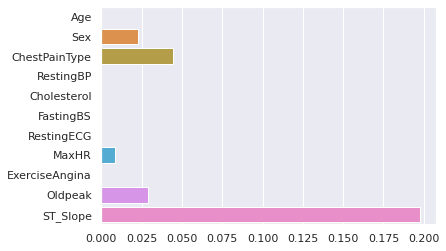

In [46]:
sns.barplot(y=data_frame.columns.to_numpy(), x=feature_gini_importance,orient='h').get_figure().savefig("1_3_gini_imp.pdf", bbox_inches='tight')

Below, we analyze the effect of varying the depth of the tree on the predictive performance. We see that as we increase depth, the tree performs perfectly (overfits) on the training data, resulting in poorer test accuracy. The optimal depth for performance seems to be 11. However, even with depth 3, the tree performs almost as well. In favour of interpretable model, we favor the latter tree.  

In [824]:
train_f1 = []
test_f1 = []
for i in range(2,17):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf = clf.fit(data_frame, target_label)
    predictions = clf.predict_proba(data_frame)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy - training set
    accuracy = np.sum(predicted_labels == target_label) / len(target_label)
    train_f1.append(f1_score(target_label, predicted_labels))

    #test_target = test_frame.pop("HeartDisease")
    predictions = clf.predict_proba(test_frame)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy - test set
    accuracy = np.sum(predicted_labels == test_target) / len(test_target)
    test_f1.append(f1_score(test_target, predicted_labels))


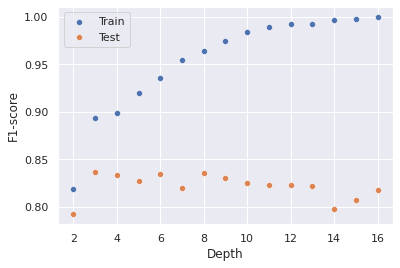

In [825]:
g = sns.scatterplot(x=np.arange(2,17), y=train_f1)
g = sns.scatterplot(x=np.arange(2,17), y=test_f1)
plt.legend(loc='upper left', labels=['Train', 'Test'])
plt.xlabel("Depth")
plt.ylabel("F1-score")
plt.savefig("1_3_depth_v_f1.pdf")
plt.show()

### Q4: Multi-Layer Perceptrons(7 Pts)
1. While often reaching superior performance, MLPs are generally hard to interpret, and it is not
straightforward to see what is happening within these models. We thus opt for post-hoc
explainability methods such as SHAP1. Post-hoc explainability methods typically use some
procedure during inference to find the feature importance per sample. Similar to Q2 and Q3,
implement a simple MLP, train it on the dataset, and report test set performance. Make sure to
report the architecture and optimization procedure you used for training.
2. Further, visualize SHAP explanations of the outputs of four positive and negative samples and
feature importances of the overall model. Are feature importances consistent across different
predictions and compared to overall importance values? Elaborate on your findings!

**Answers**
1. 
- Architecture: input-dimension (11 features = 11 units) --> fully connected to 100 hidden units --> ReLU --> output (2 units corresponding to probabilities of HeartDisease=1 or 0).
- Optimizer: Adam
- Test accuracy: 84.29% (highest of all models so far)
2. Detailed in the report

In [826]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=1, verbose=True).fit(data_frame, target_label)

predictions = clf.predict_proba(test_frame)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy - testing set
accuracy = np.sum(predicted_labels == test_target) / len(test_target)
print("Accuracy: %f" % accuracy)
print(confusion_matrix(test_target, predicted_labels), "\n", 
      precision_score(test_target, predicted_labels), recall_score(test_target, predicted_labels), 
      f1_score(test_target, predicted_labels))

Iteration 1, loss = 0.74649049
Iteration 2, loss = 0.69267532
Iteration 3, loss = 0.64456850
Iteration 4, loss = 0.60252894
Iteration 5, loss = 0.56566676
Iteration 6, loss = 0.53388288
Iteration 7, loss = 0.50512869
Iteration 8, loss = 0.48178645
Iteration 9, loss = 0.46123880
Iteration 10, loss = 0.44375549
Iteration 11, loss = 0.42834169
Iteration 12, loss = 0.41545562
Iteration 13, loss = 0.40515623
Iteration 14, loss = 0.39521947
Iteration 15, loss = 0.38697920
Iteration 16, loss = 0.38071575
Iteration 17, loss = 0.37495442
Iteration 18, loss = 0.36971519
Iteration 19, loss = 0.36533138
Iteration 20, loss = 0.36131515
Iteration 21, loss = 0.35805708
Iteration 22, loss = 0.35483689
Iteration 23, loss = 0.35252526
Iteration 24, loss = 0.35002511
Iteration 25, loss = 0.34765991
Iteration 26, loss = 0.34558677
Iteration 27, loss = 0.34384977
Iteration 28, loss = 0.34205885
Iteration 29, loss = 0.34037346
Iteration 30, loss = 0.33882847
Iteration 31, loss = 0.33738302
Iteration 32, los

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.


In [827]:
import shap
# sample 4 +ve and -ve samples (that the model has classified correctly)
positive_samples = test_target.loc[predicted_labels == test_target].loc[lambda x: x==1].sample(4,random_state=1).index
negative_samples = test_target.loc[predicted_labels == test_target].loc[lambda x: x==0].sample(4,random_state=1).index
shap.initjs()
explainer = shap.KernelExplainer(clf.predict, shap.sample(data_frame, random_state=1))
shap_values_pos = explainer.shap_values(test_frame.loc[positive_samples])
shap_values_neg = explainer.shap_values(test_frame.loc[negative_samples])

X does not have valid feature names, but MLPClassifier was fitted with feature names
  0%|          | 0/4 [00:00<?, ?it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
 25%|██▌       | 1/4 [00:00<00:01,  1.68it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
 50%|█████     | 2/4 [00:01<00:01,  1.69it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
 75%|███████▌  | 3/4 [00:01<00:00,  1.69it/s]X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
  0%|          | 0/4 [00:00<?, ?it/s]X does not have valid feat

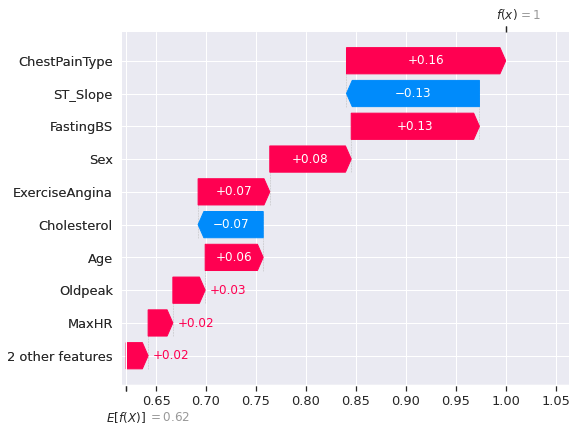

In [828]:
# The shap.plots.waterfall expects an object with the members defined in Shap class below. 
# Seems like their API is broken, hence this workaround
class Shap:
    def __init__(self, base_values, feature_names, shap_values):
        self.base_values = base_values
        self.feature_names = feature_names
        self.values = shap_values
        self.data = None
shap.plots.waterfall(Shap(explainer.expected_value, data_frame.columns, shap_values_pos[0]))

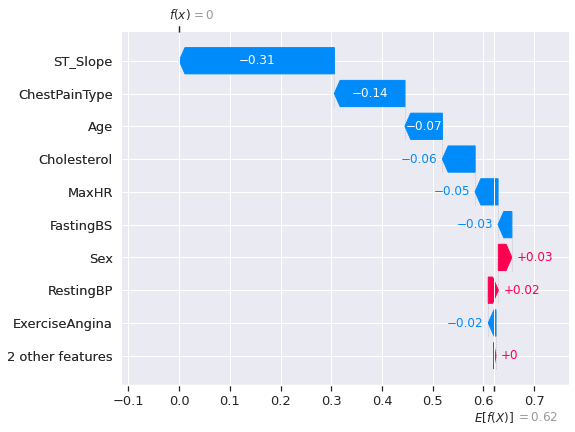

In [829]:
shap.plots.waterfall(Shap(explainer.expected_value, data_frame.columns, shap_values_neg[3]))

We also visualize the global feature importance, by averaging absolute Shapely values over dataset for each feature and observe that they mostly agree with the findings of Lasso regression and decision tree models.

In [ ]:
shap_values = explainer.shap_values(test_frame)

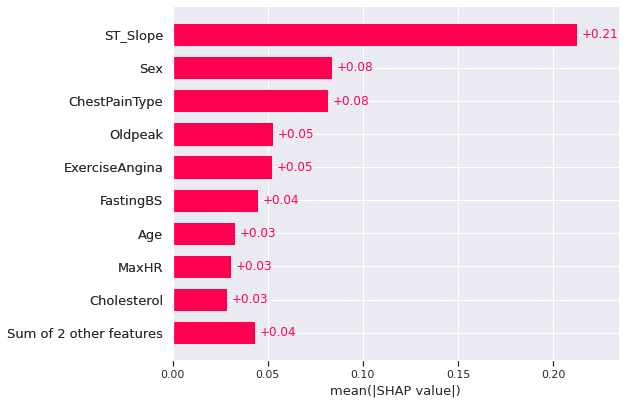

In [833]:
shap.plots.bar(shap.Explanation(shap_values, feature_names=data_frame.columns))